#  11.5 Capstone Two: Exploratory Data Analysis

### Step 1: Loading Data

In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from scipy.stats import t
from scipy import stats

from numpy.random import seed
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from library.sb_utils import save_file

In [2]:
#Loading the two csv with and without dummy variables (one-hot variable)
df = pd.read_csv('data/insurance_r1.csv') 
df_r = pd.read_csv('data/insurance_regression.csv') 

### Step 2: Explorating the data

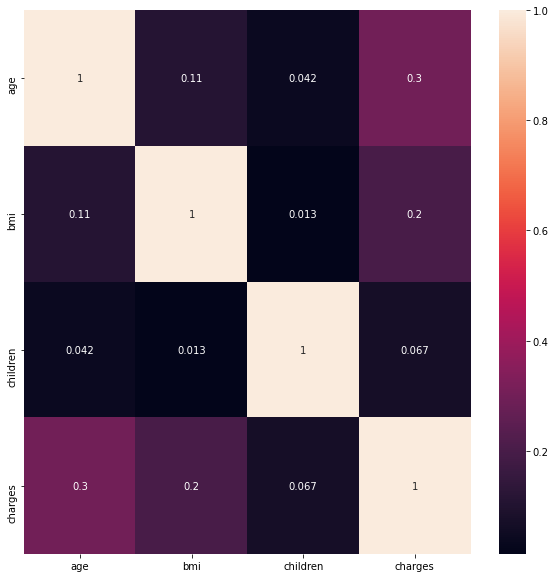

In [3]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

From the heatmap, the numerical factors seem to have no strong correlation between each other.

In [4]:
# define useful function to create scatterplots of ticket prices against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'charges', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='Insurance fee')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [5]:
features = [i for i in df.columns if i not in ['charges']]

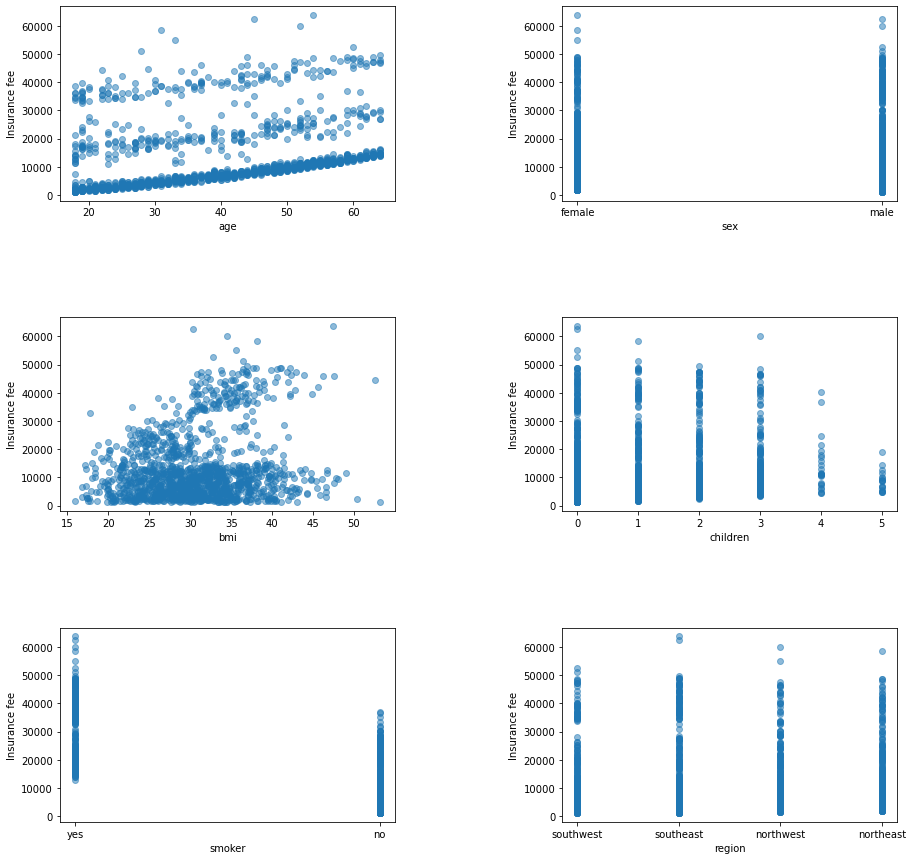

In [6]:
scatterplots(features, ncol=2, figsize=(15, 15))

From the scatter plot we can observe:

Age: There are 3 discrete line we can draw from the scatter plot. This indicate clusters may exist

Sex: No obvious different in insurance fee between male and female

bmi: There is no obvious trend but we can observe that most people which have 30k+ insurance free 
have bmi 30 or higher.

children: The people which have 4 and 5 children tend to have a lower insurance fee compared with people who have 1-3 children

smoker: Smoker have higher insurance fee

region: There is no obvious different between people in different region

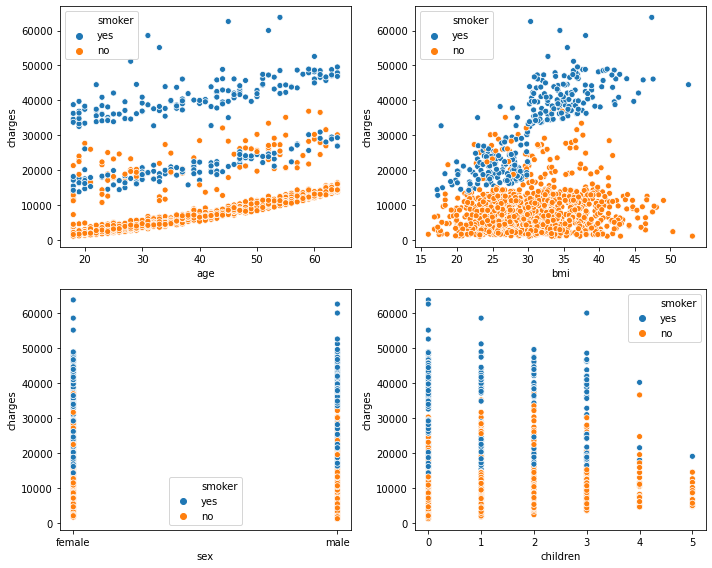

In [7]:
#Explore any cluster formed by smoking behaviour
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'smoker',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'smoker',ax = axes[0,1])
sns.scatterplot(x = 'children', y = 'charges',data = df,hue = 'smoker',ax = axes[1,1])
sns.scatterplot(x = 'sex', y = 'charges',data = df,hue = 'smoker',ax = axes[1,0])

plt.tight_layout()
plt.show()

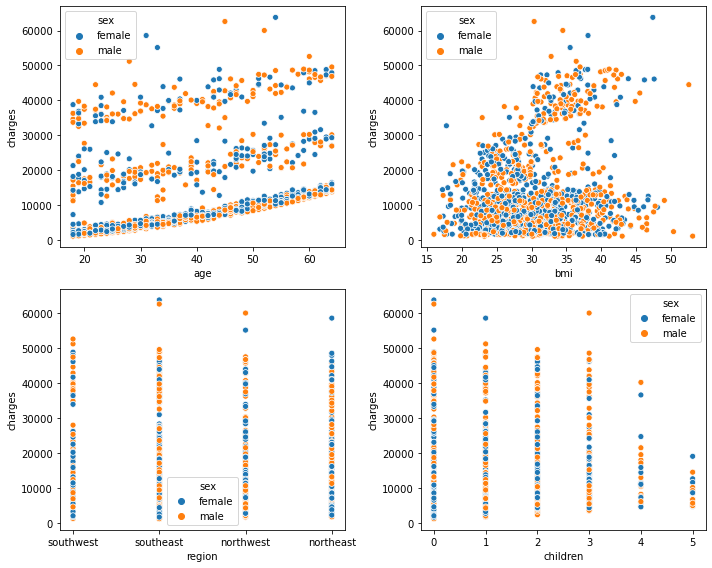

In [8]:
#Explore any cluster formed by sex
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'sex',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'sex',ax = axes[0,1])
sns.scatterplot(x = 'children', y = 'charges',data = df,hue = 'sex',ax = axes[1,1])
sns.scatterplot(x = 'region', y = 'charges',data = df,hue = 'sex',ax = axes[1,0])
plt.tight_layout()


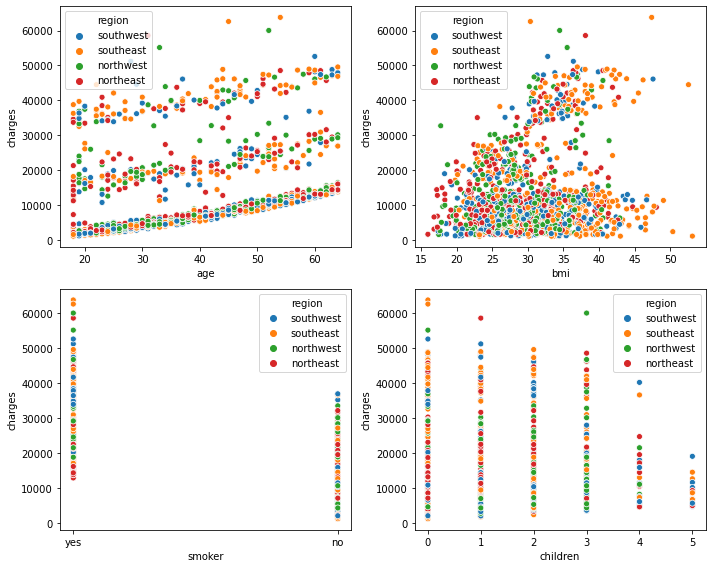

In [9]:
#Explore any cluster formed by region
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'region',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'region',ax = axes[0,1])
sns.scatterplot(x = 'children', y = 'charges',data = df,hue = 'region',ax = axes[1,1])
sns.scatterplot(x = 'smoker', y = 'charges',data = df,hue = 'region',ax = axes[1,0])
plt.tight_layout()


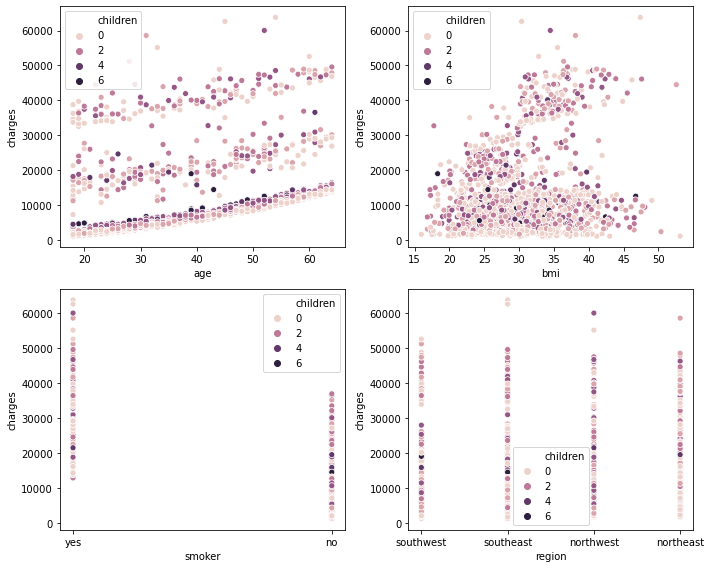

In [10]:
#Explore any cluster formed by sex family size
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'children',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'children',ax = axes[0,1])
sns.scatterplot(x = 'region', y = 'charges',data = df,hue = 'children',ax = axes[1,1])
sns.scatterplot(x = 'smoker', y = 'charges',data = df,hue = 'children',ax = axes[1,0])
plt.tight_layout()


We can observe a cluster from smoking behaviour. The cluster indicates that both insurance fee of the smokers and non-smokers increase with age (with similar slope) while the smokers have a higher y-intercept (insurance fee). Moreover, the insurance fee of non-smokers have no obvious trend with bmi but that of the smokers increase with bmi.

### Step 3: Statistical Test

In [11]:
#t-test for smoker
smoker = df[df['smoker']=='yes'].charges
nonsmoker = df[df['smoker']=='no'].charges
result = ttest_ind(nonsmoker,smoker)
print('t_stat is {}'.format(result[0]),
      '\np-value is {}'.format(result[1]))

t_stat is -46.64479471596229 
p-value is 1.4067191603310468e-282


In [12]:
#t-test for sex
female = df[df['sex']=='female'].charges
male = df[df['sex']=='male'].charges
result = ttest_ind(female,male)
print('t_stat is {}'.format(result[0]),
      '\np-value is {}'.format(result[1]))

t_stat is -2.1243917376752517 
p-value is 0.03382075594788481


In [13]:
#One-Way ANOVA for region
SW = df[df['region']=='southwest'].charges
SE = df[df['region']=='southeast'].charges
NW = df[df['region']=='northwest'].charges
NE = df[df['region']=='northeast'].charges
f_oneway(SW, SE, NW,NE)


F_onewayResult(statistic=2.926140081112945, pvalue=0.03276287240528303)

In [14]:
#One-Way ANOVA for family size

chil_0 = df[df['children']==0].charges
chil_1 = df[df['children']==1].charges
chil_2 = df[df['children']==2].charges
chil_3 = df[df['children']==3].charges
chil_4 = df[df['children']==4].charges
chil_5 = df[df['children']==5].charges

f_oneway(chil_0, chil_1, chil_2,chil_3,chil_4,chil_5)


F_onewayResult(statistic=3.2687345369236396, pvalue=0.006133446579312973)

In [15]:
#Two-way ANOVA (trial 1)
model = ols('charges ~ age + bmi + C(children) + C(region) + C(sex)+ C(smoker)', data=df).fit()


In [16]:
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(children),6.362877e+08,5.0,3.464127,4.087453e-03
C(region),2.268326e+08,3.0,2.058233,1.039587e-01
C(sex),5.295336e+06,1.0,0.144146,7.042541e-01
C(smoker),1.215702e+11,1.0,3309.311288,0.000000e+00
age,1.706908e+10,1.0,464.644261,1.417957e-88
bmi,5.090388e+09,1.0,138.567451,1.708772e-30
Residual,4.863822e+10,1324.0,NaN,NaN


In [17]:
#Two-way ANOVA (trial 2)
mod = ols('charges ~ age + bmi + C(children_0) + C(children_1) + C(children_2)\
+ C(children_3)+ C(children_4)+ C(children_5)+ C(SW) + C(SE) + C(NW) + C(NE) + C(sex)\
+ C(smoker)', data=df_r).fit()

In [18]:
sm.stats.anova_lm(mod, typ=2)


,sum_sq,df,F,PR(>F)
C(children_0),1.587973e+09,1.0,43.226828,6.995766e-11
C(children_1),9.103150e+08,1.0,24.780042,7.271708e-07
C(children_2),1.320036e+08,1.0,3.593323,5.822975e-02
C(children_3),3.206390e+08,1.0,8.728241,3.188542e-03
C(children_4),6.113768e+06,1.0,0.166425,6.833745e-01
C(children_5),4.629478e+07,1.0,1.260209,2.618152e-01
C(SW),1.776769e+09,1.0,48.366114,5.540498e-12
C(SE),1.569372e+09,1.0,42.720503,8.988701e-11
C(NW),1.093463e+09,1.0,29.765593,5.812771e-08
C(NE),6.824791e+08,1.0,18.578032,1.751601e-05


### Step 4: Preliminary OLS Model

In [21]:
df_r.dtypes
df_r[['sex','smoker','children_0','children_1','children_2','children_3','children_4','children_5','SW','SE','NW','NW']] = df_r[['sex','smoker','children_0','children_1','children_2','children_3','children_4','children_5','SW','SE','NW','NW']].astype("category")
df_r.dtypes


age              int64
sex           category
bmi            float64
smoker        category
charges        float64
children_0    category
children_1    category
children_2    category
children_3    category
children_4    category
children_5    category
SW            category
SE            category
NW              object
NE               int64
dtype: object

In [25]:
X = df_r.drop(columns='charges')
X = pd.get_dummies(data=X, drop_first=True)
X.dtypes

age               int64
bmi             float64
NE                int64
sex_1             uint8
smoker_1          uint8
children_0_1      uint8
children_1_1      uint8
children_2_1      uint8
children_3_1      uint8
children_4_1      uint8
children_5_1      uint8
SW_1              uint8
SE_1              uint8
NW_1              uint8
dtype: object

In [26]:
Y = df_r.charges
X = sm.add_constant(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, test_size=0.3, 
                                                    random_state=47)

In [29]:
# Create the model
model = sm.OLS(y_train,X_train)

# Fit the model with fit() 
results = model.fit()

In [31]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     207.1
Date:                Fri, 22 Jan 2021   Prob (F-statistic):          7.66e-252
Time:                        21:18:57   Log-Likelihood:                -9472.6
No. Observations:                 935   AIC:                         1.897e+04
Df Residuals:                     922   BIC:                         1.903e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7239.1198    868.191     -8.338      0.000   -8942.980   -5535.260
age            261.9942     14.362     18.242      0.000     233.808     290.180
bmi            295.0231     35.422      8.329      0.000     225.505     364.541
NE           -1744.4003    390.111     -4.472      0.000   -2510.009    -978.792
sex_1           70.4981    402.658      0.175      0.861    -719.735     860.731
smoker_1      2.268e+04    508.044     44.648      0.000    2.17e+04    2.37e+04
children_0_1 -2241.5903    438.888     -5.107      0.000   -3102.927   -1380.254
children_1_1 -2019.8903    493.505     -4.093      0.000   -2988.414   -1051.366
children_2_1  -720.1244    544.993     -1.321      0.187   -1789.695     349.447
children_3_1 -1410.2164    619.811     -2.275      0.023   -2626.620    -193.813
children_4_1   393.7816   1185.105      0.332      0.740   -1932.035    2719.598
children_5_1 -1241.0800   1332.451     -0.931      0.352   -3856.068    1373.908
SW_1         -1999.3626    418.608     -4.776      0.000   -2820.898   -1177.827
SE_1         -2183.0419    458.155     -4.765      0.000   -3082.190   -1283.894
NW_1         -1312.3150    393.747     -3.333      0.001   -2085.060    -539.570
==============================================================================
Omnibus:                      230.569   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              523.089
Skew:                           1.337   Prob(JB):                    2.59e-114
Kurtosis:                       5.506   Cond. No.                     5.30e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.84e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [32]:
Y_pred = results.predict(X_test)

In [39]:
r2_score(Y_pred,y_test)

0.6496716907500053